In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixture, GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.06.07


In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

In [4]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = np.log(A[msk])
    Y = np.log(B[msk])
    plt.loglog(A[msk],A[msk],'k')
    plt.plot(A[msk],B[msk],'.', \
           label="CCC="+str(np.round(CCC(X,Y),2))\
             +"\nPearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2)));
    plt.legend(fontsize=15)

# Load data

## Download data
!curl https://zenodo.org/record/4719436/files/velocity_anndata_human_fibroblast_DeepCycle_ISMARA.h5ad?download=1 \
    --output data/CellCycle/velocity_anndata_human_fibroblast_DeepCycle_ISMARA.h5ad

## Load counts

In [11]:
their_adata = sc.read('data/CellCycle/velocity_anndata_human_fibroblast_DeepCycle_ISMARA.h5ad')
their_adata.var_names_make_unique
their_adata

AnnData object with n_obs × n_vars = 5367 × 10789
    obs: 'Clusters', '_X', '_Y', 'sample', 'n_genes', 'percent_mito', 'n_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'clusters_gradients', 'leiden', 'cell_cycle_theta'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'gene_count_corr'
    uns: 'ISMARA_activities', 'clusters_gradients_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [18]:
#alldata = sc.read('/home/mffang/data/counts/DeepCycle/SRR13790992/counts_filtered/adata.loom',validate=False)
their_barcodes = [ bc[6:-1] for bc in their_adata.obs_names ]
cell_idx = [np.where(alldata.obs['barcode']==bc)[0][0] for bc in their_barcodes]
adata = alldata[cell_idx]
adata.obsm = their_adata.obsm.copy()
adata.var_names = adata.var['gene_name'].astype(str)
adata

AnnData object with n_obs × n_vars = 5367 × 62710
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    obsm: 'X_pca', 'X_umap'
    layers: 'matrix', 'spliced', 'unspliced'

Text(0.5, 0, 'theirs')

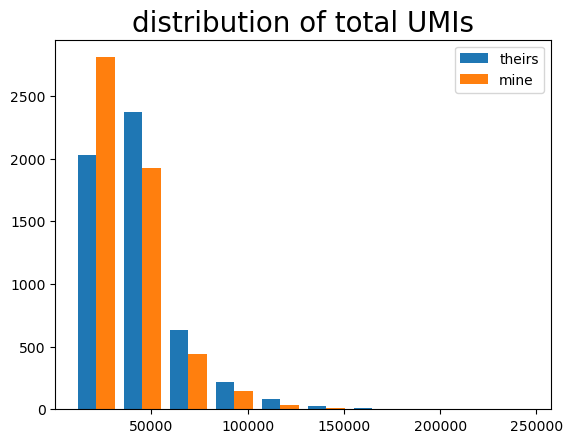

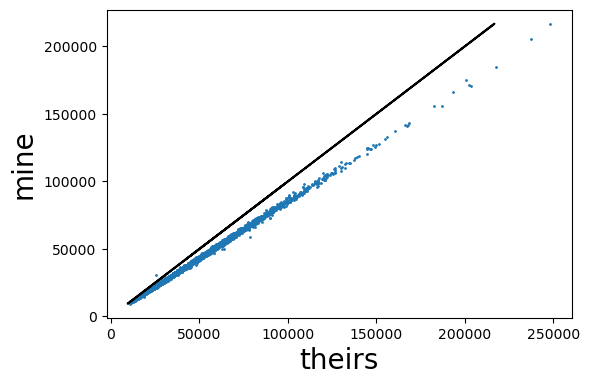

In [19]:
adata_total_UMI =  adata.layers['unspliced'].toarray().sum(1) + adata.layers['spliced'].toarray().sum(1)

plt.hist([their_adata.layers['matrix'].toarray().sum(1),adata_total_UMI],label=['theirs','mine'])
plt.legend()
plt.title('distribution of total UMIs',fontsize=20)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(adata_total_UMI,adata_total_UMI,'k')
ax.scatter(their_adata.layers['matrix'].toarray().sum(1),adata_total_UMI,s=1)
plt.ylabel("mine",fontsize=20)
plt.xlabel("theirs",fontsize=20)

## Load degradation rates data

In [20]:
# TimeLaspe-seq, human K562 cell line
file_path = 'data/Schofield_ST2.xlsx'
Schofield = pd.read_excel(file_path,sheet_name='Table S2_K562')

# Calculate decay rate
Schofield['Decay Rate'] = np.log(2) / Schofield['mean_half_life']
Schofield = Schofield[~Schofield['Decay Rate'].isna()]

Schofield.head()

gene_name = adata.var_names.tolist()
Schofield_gamma = []
data_genes = np.array(Schofield['transcript'].tolist())
data_rates = np.array(Schofield['Decay Rate'].tolist())
nan = 0 

for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Schofield_gamma.append(data_rates[idx])
    else:
        Schofield_gamma.append(np.nan)
        nan += 1
        
Schofield_gamma = np.array(Schofield_gamma)
nan 

57537

In [21]:
# Dyrec-seq, Hela cell
file_path = 'data/Dyrec-seq_ST.xlsx'
df = pd.read_excel(file_path,sheet_name='Table S4',header=2)
#df.head()

# Extract gene name and decay rate columns
Dyrec_data = df.iloc[:,[1,3]].copy()
Dyrec_data.columns = ['Name', 'Decay Rate']

# Print the extracted data
Dyrec_data.head()

Dyrec_gamma = []
data_genes = np.array([gene.upper() for gene in Dyrec_data['Name'].astype(str).tolist()])
data_rates = np.array(Dyrec_data['Decay Rate'].tolist())

gene_name = adata.var_names.tolist()
nan = 0 
for gene in gene_name:
    if gene in data_genes:
        idx = np.where(data_genes==gene)[0][0]
        Dyrec_gamma.append(data_rates[idx])
    else:
        Dyrec_gamma.append(np.nan)
        nan += 1
        
Dyrec_gamma = np.array(Dyrec_gamma)
nan 

58221

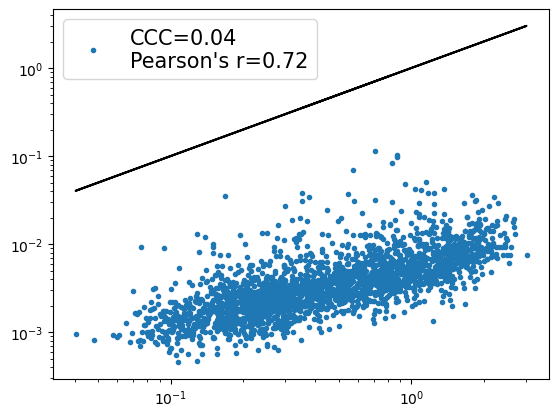

In [25]:
A = Schofield_gamma
B = Dyrec_gamma
plot_cor(A,B)

## EDA

In [26]:
clusters = np.around(their_adata.obs['cell_cycle_theta'],1)
Clusters = set(clusters)
Clusters

{0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0}

In [27]:
color_palette = ["#84b753","#c3d585","#d3e4e2","#77a6ac","#405759"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = cmap_cluster(clusters)

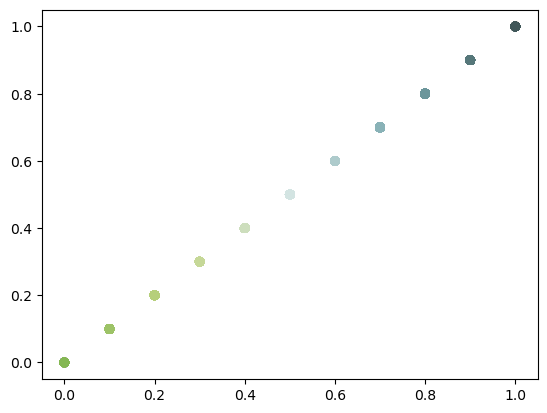

In [28]:
plt.scatter(clusters,clusters,c=cell_colors)

In [32]:
x = their_adata.obsm['X_pca']

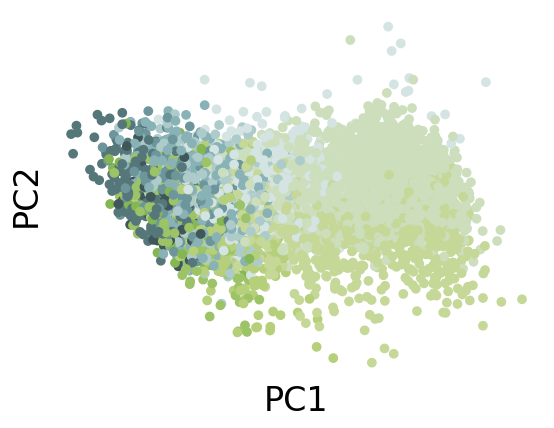

In [33]:
fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [34]:
known_marker_genes=["Geminin", "Cdt1", 'Mcm6', 'Mcmc2','Cdk1','Top2a','Kif11',"Plk1","RFC1"]
marker_genes=np.array(["Geminin", "Cdt1", 'Mcm6', 'Mcmc2','Cdk1','Cdk2','Cdk3','Cdk4','Cdk5','Top2a','Kif11',"Plk1","RFC1"])
marker_genes=adata.var_names[adata.var_names.isin(marker_genes)]
marker_genes

Index(['RFC1'], dtype='object', name='gene_name')

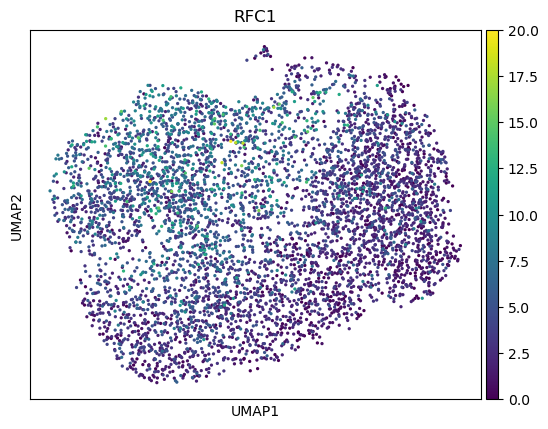

In [35]:
sc.pl.umap(adata,color=marker_genes)

# Select genes

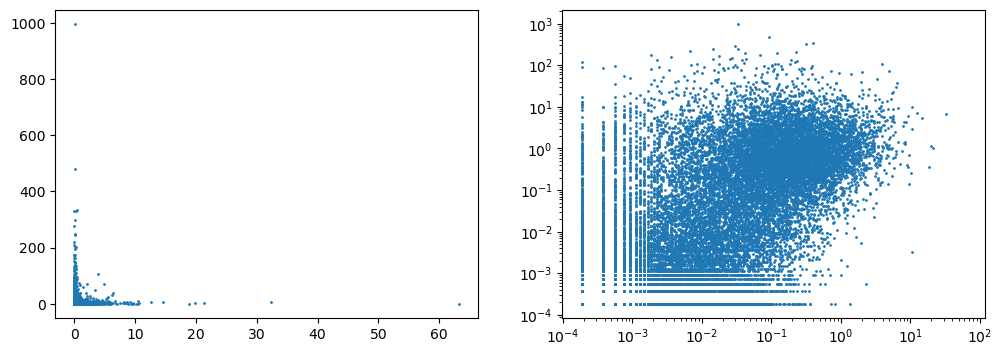

In [36]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [37]:
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

KeyboardInterrupt: 

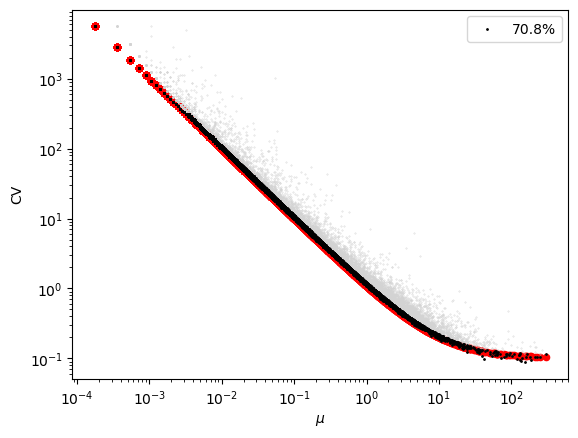

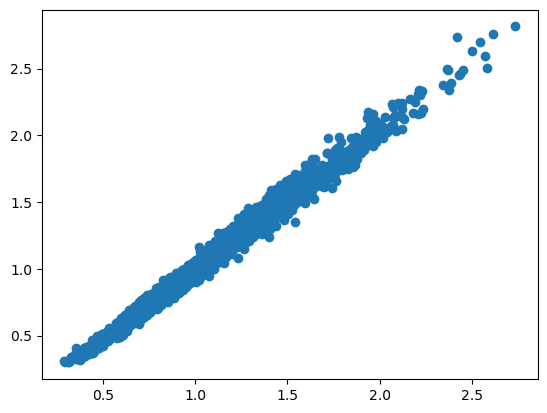

In [395]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()

X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)
a=1
s=s2
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

In [396]:
cell_cycle_genes = pd.read_csv('data/cell_cycle_genes.txt',header=None)
cell_cycle_genes = np.array(cell_cycle_genes[0],dtype=str)
ccg_idx = adata.var["gene_name"].isin(cell_cycle_genes)
ccg_idx.sum()

1278

/tmp/ipykernel_2130354/1594038497.py:7: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + su*U_mean**2) > CV_threshold) \
/tmp/ipykernel_2130354/1594038497.py:8: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + ss*S_mean**2) > CV_threshold) \
/tmp/ipykernel_2130354/1594038497.py:9: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_2130354/1594038497.py:9: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_2130354/1594038497.py:9: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_2130354/1594038497.py:12: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
/tmp/ipykernel_2130354/1594038497.py:13: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
/tmp

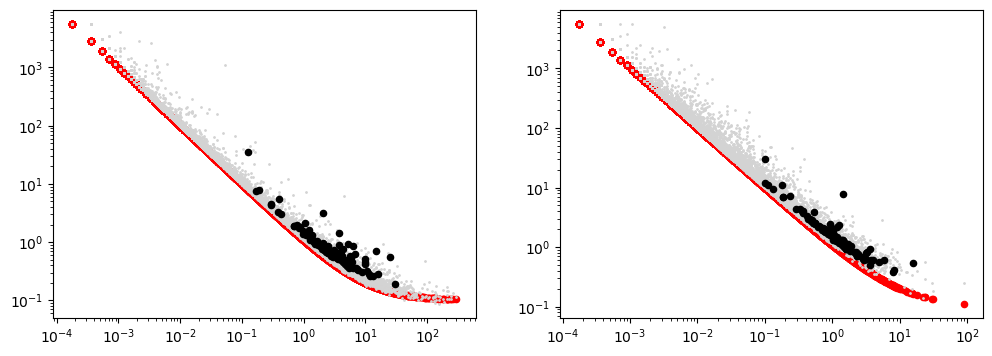

In [553]:
CV_threshold = 1.2
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = ccg_idx & (U_mean > 0.1) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + su*U_mean**2) > CV_threshold) \
    & (S_var/(a*S_mean + ss*S_mean**2) > CV_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

128


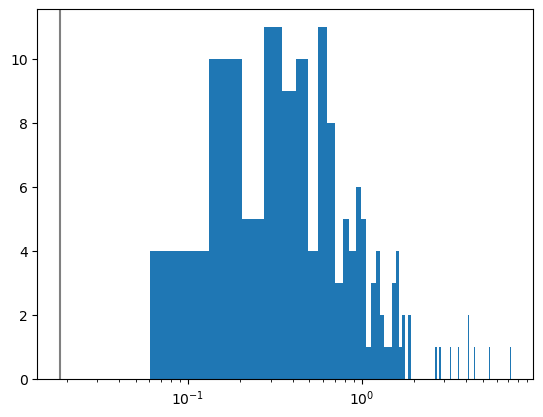

In [554]:
gene_length_file = np.loadtxt("data/gg_200524_mouse_genome_polyA_cum_1.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(np.sum(fitted_idx))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ],dtype=int)
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

In [555]:
fitted_idx = adata.var_names.isin(fitted_genes)

X=np.zeros((n,overlap_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

(5637, 128, 2)

In [538]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Top2a'], dtype='object', name='gene_name')


In [539]:
ref_gamma = slam_gamma[fitted_idx]

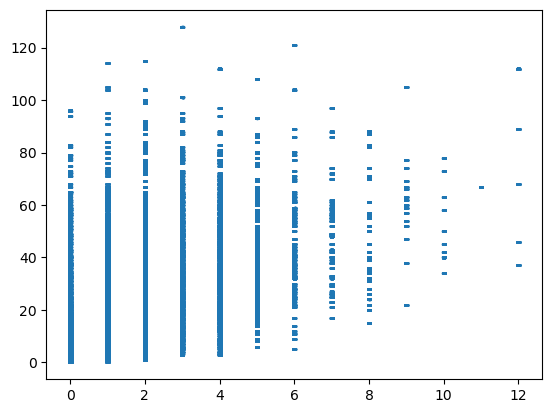

In [540]:
if len(plot_idx) == 1:
    j = plot_idx
    plt.scatter(X[:,j,0]+np.random.normal(0,0.01,X.shape[0]),X[:,j,1]+np.random.normal(0,0.01,X.shape[0]),s=0.5,alpha=0.5)
else:
    fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
    for i in range(pp):
        j = plot_idx[i]
        ax[i].set_title(fitted_genes[j])
        ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [541]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

In [542]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    print(nc,PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

1 -472.25472646723176 -472.40543601714745
2 -459.2834081711171 -459.5854159801278
3 -455.1654631817872 -455.61876924989275
4 -452.3486390109591 -452.9532433381597
5 -451.1372224648288 -451.8931250511244
6 -449.76395757308126 -450.67115841847186


array([0.39944652, 0.60055348])

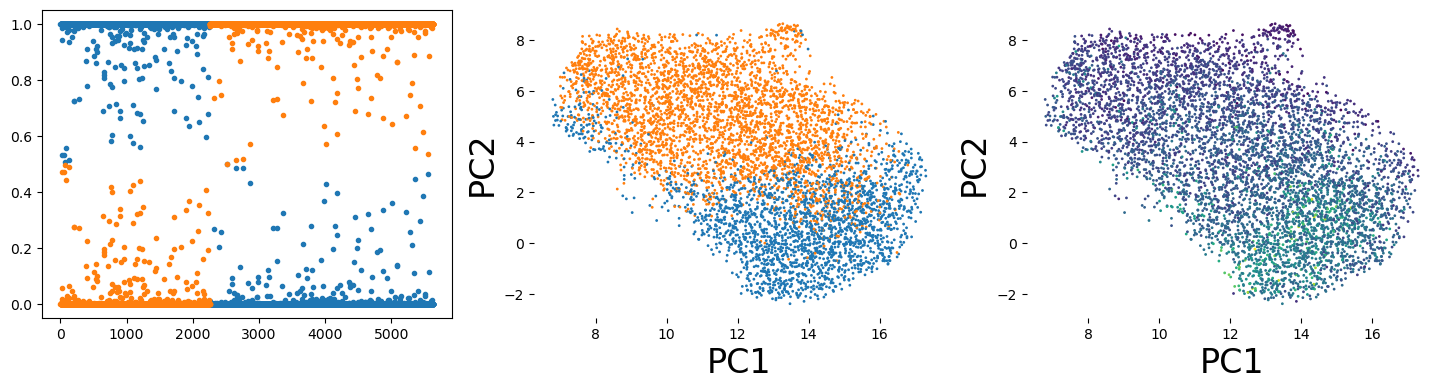

In [605]:
PM = PoissonMixture(n_components=2,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

ax[2].scatter(x[:,0],x[:,1],c=rd,s=1);
ax[2].set_xlabel('PC1',fontsize=24)
ax[2].set_ylabel('PC2',fontsize=24)
ax[2].set_frame_on(False)
PM.weights

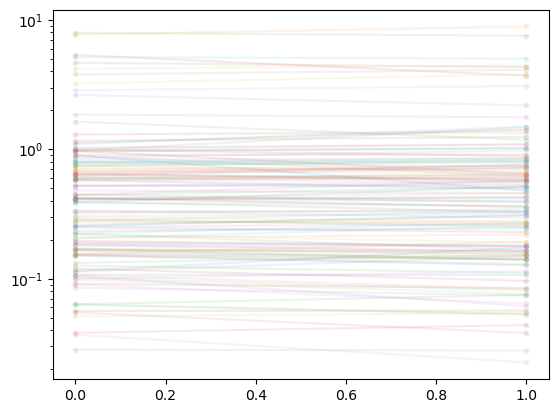

In [606]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

array([0.23826891, 0.27479854, 0.48693256])

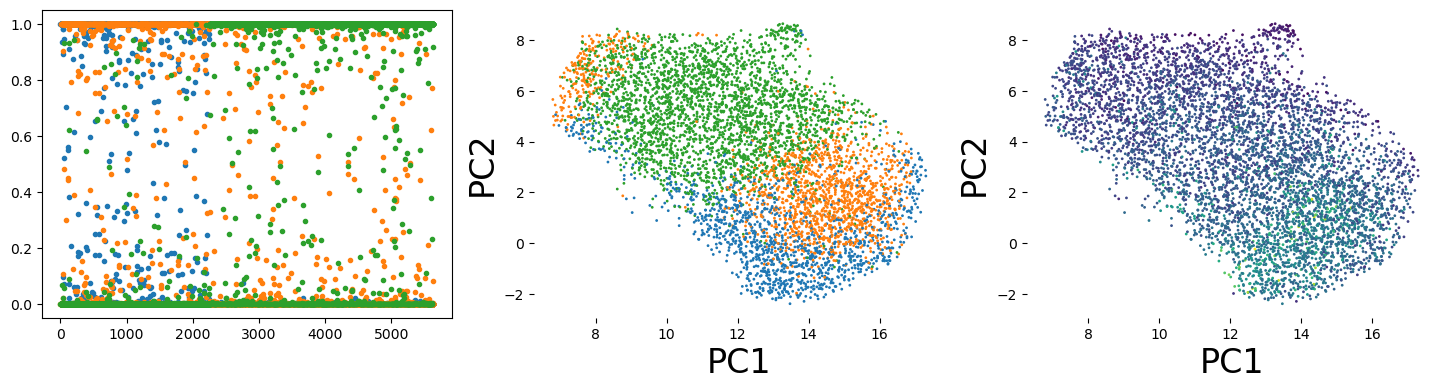

In [544]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=1)],s=1);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

ax[2].scatter(x[:,0],x[:,1],c=rd,s=1);
ax[2].set_xlabel('PC1',fontsize=24)
ax[2].set_ylabel('PC2',fontsize=24)
ax[2].set_frame_on(False)
PM.weights

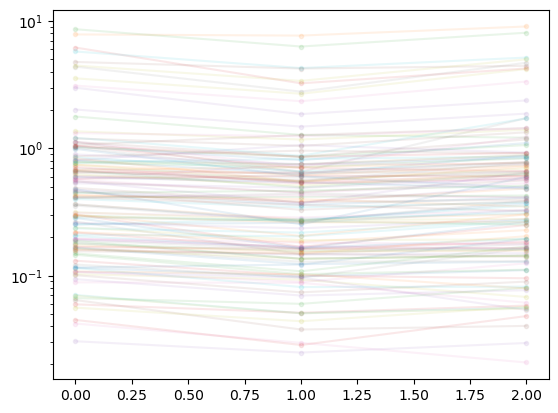

In [604]:
gbr = PM.theta[:,:,0]/PM.theta[:,:,1]

plt.plot(gbr,'.-',alpha=0.1);
plt.yscale('log')

# Trajectory fitting

In [497]:
elbos = {}
params={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_tau":0}

## Fine cluster

In [607]:
clusters = pd.Series(np.argmax(Q,axis=1))
#clusters = np.around(xx/xx.max()*2,0)
Clusters = [1,0]

NameError: name 'xx' is not defined

In [499]:
m=100
weight0 = np.ones((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 0.01
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

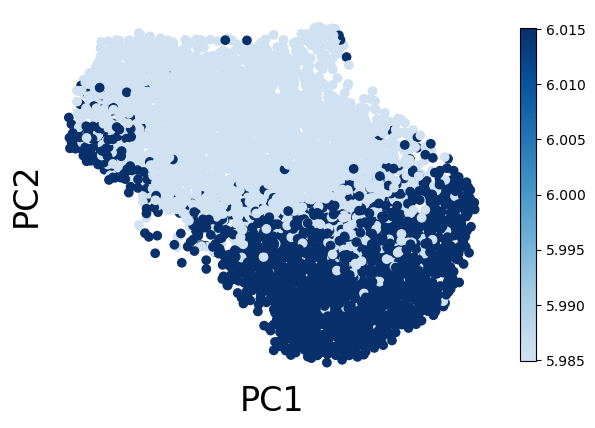

In [500]:
t_hat = Q0.sum(1)@np.linspace(0,12,m)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [545]:
topo = np.array([[0,1,2,0]])
tau = (0,6,8,10)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 100/100 [05:07<00:00,  3.08s/it]

-450.95813250857157


[ 0.          3.40819846  6.33731587 10.        ]


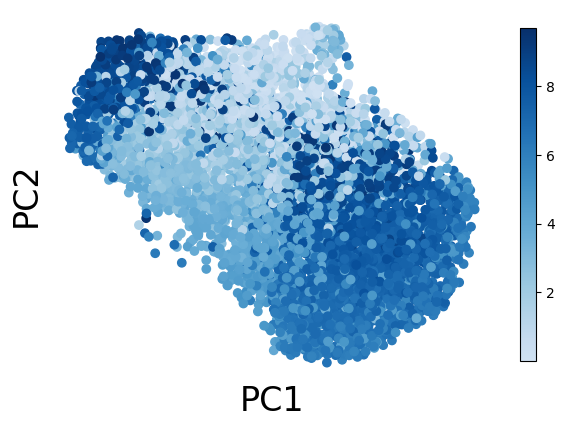

In [546]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

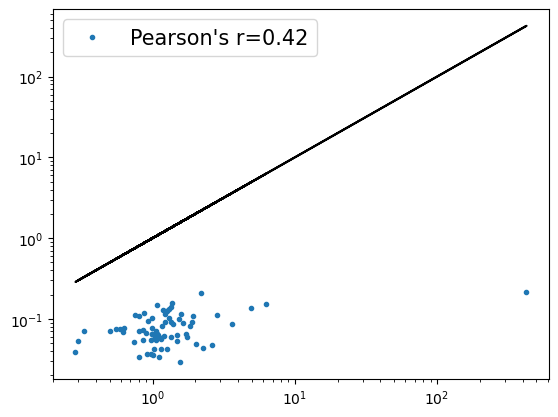

In [547]:
A = traj.theta[:,-1]
B = Selbach_gamma[fitted_idx]
plot_cor(A,B)

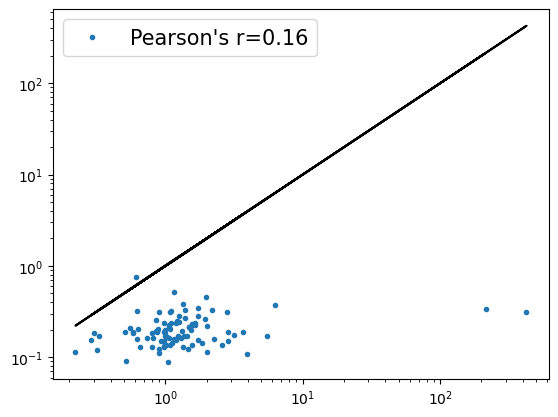

In [548]:
A = traj.theta[:,-1]
B = slam_gamma[fitted_idx]
plot_cor(A,B)

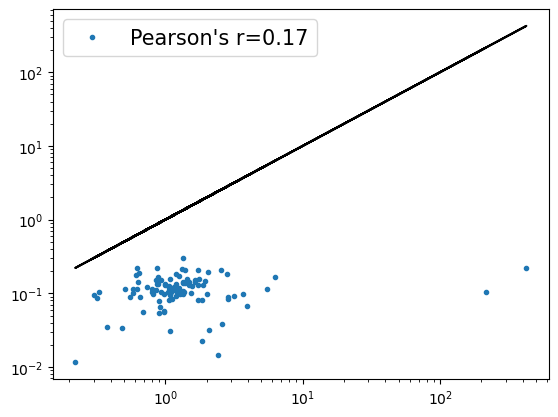

In [549]:
A = traj.theta[:,-1]
B = Sharova_gamma[fitted_idx]
plot_cor(A,B)

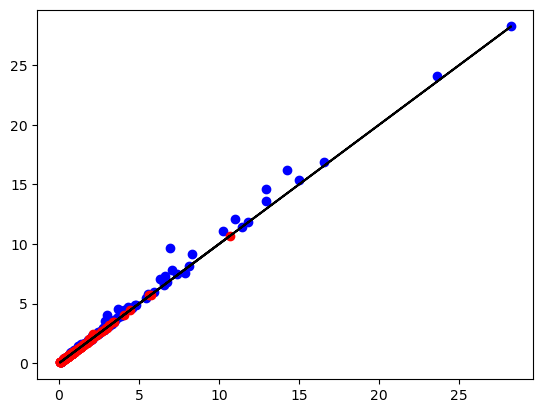

In [550]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
plt.plot(Y[0,0,:,0],Y[0,0,:,0],'k-')
plt.plot(Y[0,0,:,1],Y[0,0,:,1],'k-')
plt.scatter(Y[0,0,:,1],Y[0,-1,:,1],color='b')
plt.scatter(Y[0,0,:,0],Y[0,-1,:,0],color='r')

In [506]:
params={'r':rd,"Ub":Ub,"lambda_tau":0,"lambda_tau":0}
traj_tau = Trajectory(traj.topo, traj.tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,params=params,Q=traj.Q.copy(),parallel=True,n_threads=10,epoch=100)
print(traj_tau.compute_AIC(X,standard=False))

fitting with warm start


100%|██████████| 100/100 [08:19<00:00,  4.99s/it]

-566.0884384729882


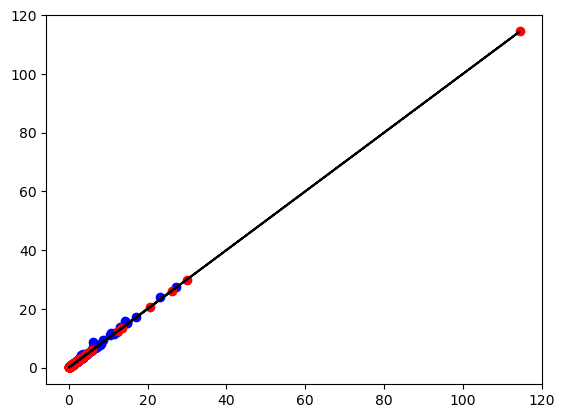

In [528]:
Y = traj_tau.get_Y_hat(traj_tau.theta, traj_tau.t, traj_tau.tau, traj_tau.topo, traj_tau.params)
plt.plot(Y[0,0,:,0],Y[0,0,:,0],'k-')
plt.plot(Y[0,0,:,1],Y[0,0,:,1],'k-')
plt.scatter(Y[0,0,:,1],Y[0,-1,:,1],color='b')
plt.scatter(Y[0,0,:,0],Y[0,-1,:,0],color='r')

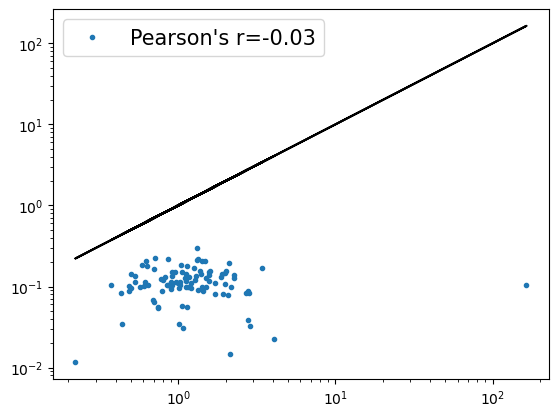

In [529]:
A = traj_tau.theta[:,-1]
B = Sharova_gamma[fitted_idx]
plot_cor(A,B)

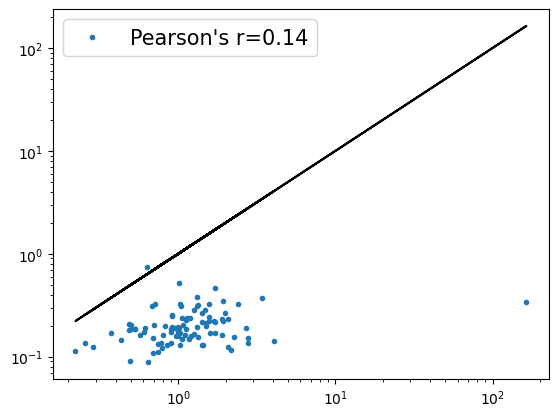

In [530]:
A = traj_tau.theta[:,-1]
B = slam_gamma[fitted_idx]
plot_cor(A,B)

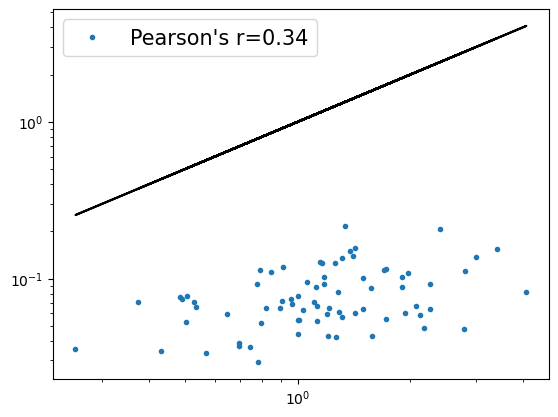

In [531]:
A = traj_tau.theta[:,-1]
B = Selbach_gamma[fitted_idx]
plot_cor(A,B)

[]

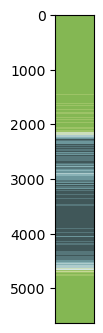

In [516]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

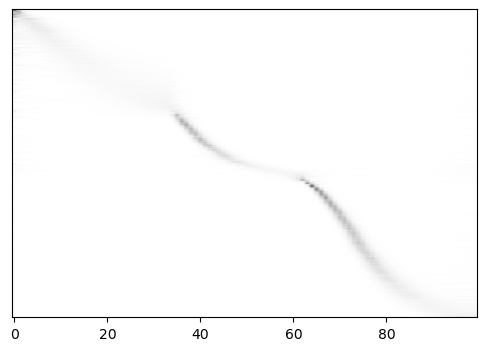

In [517]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

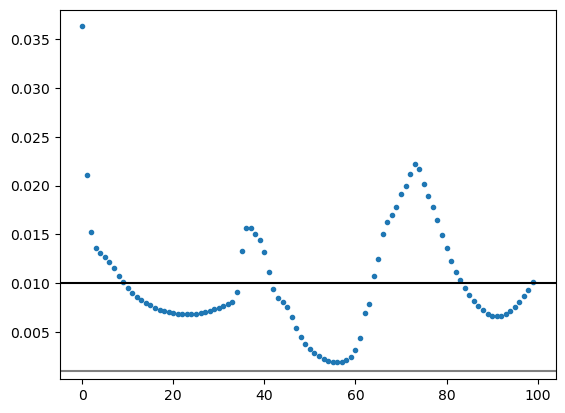

In [518]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

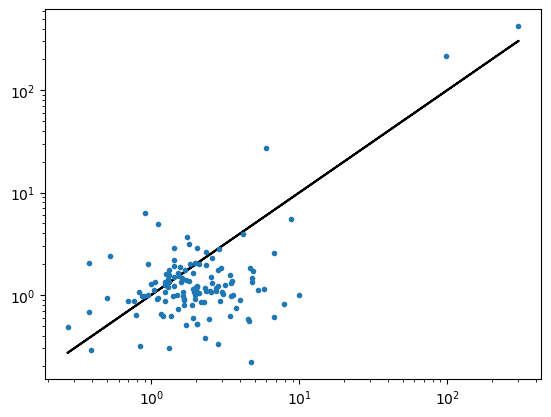

In [519]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k')
plt.plot(traj.theta[:,-2],traj.theta[:,-1],'.');

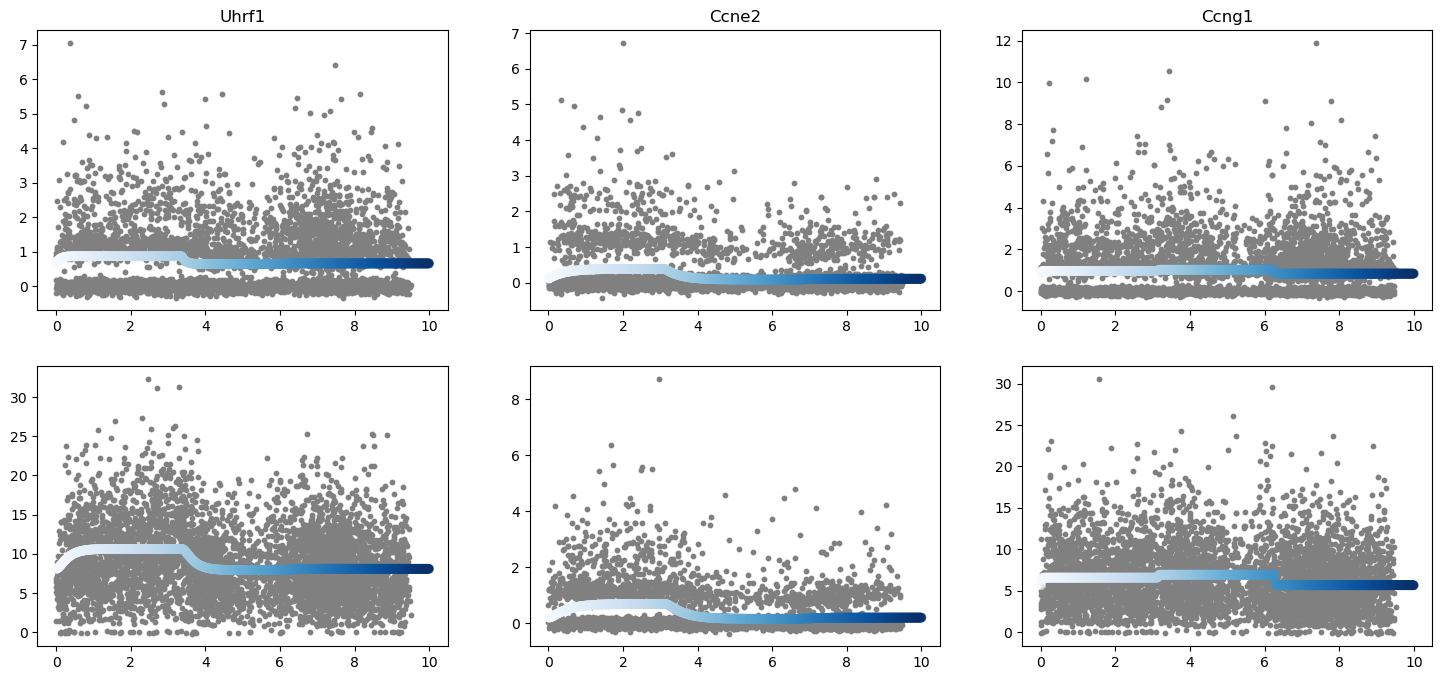

In [520]:
plot_y(traj_tau,X=X/rd[:,None,None],idx=np.argsort(traj_tau.theta[:,-1])[-3:],gene_name=fitted_genes);

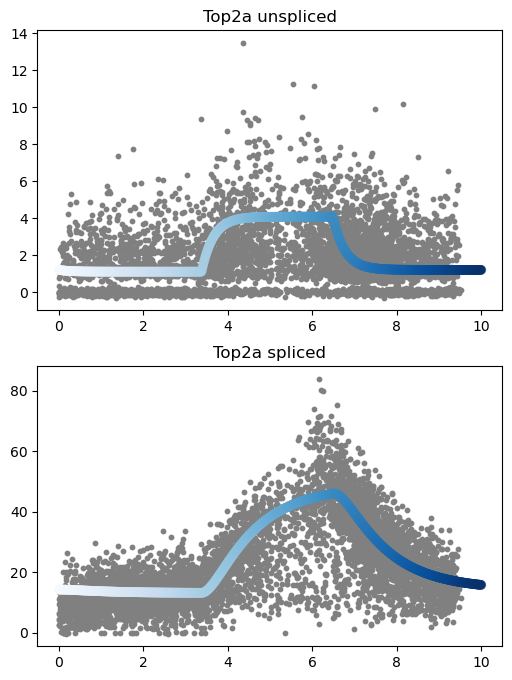

In [521]:
plot_y(traj_tau,X=X/rd[:,None,None],idx=plot_idx,gene_name=fitted_genes);

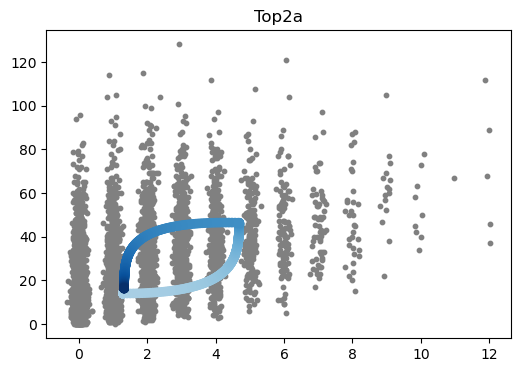

In [522]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

In [523]:
plot_marker_genes = ['Cdt1','Mcm2']

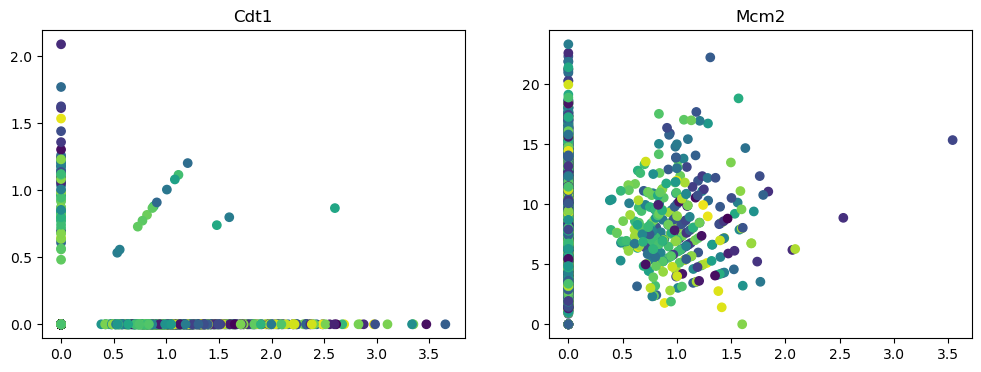

In [524]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

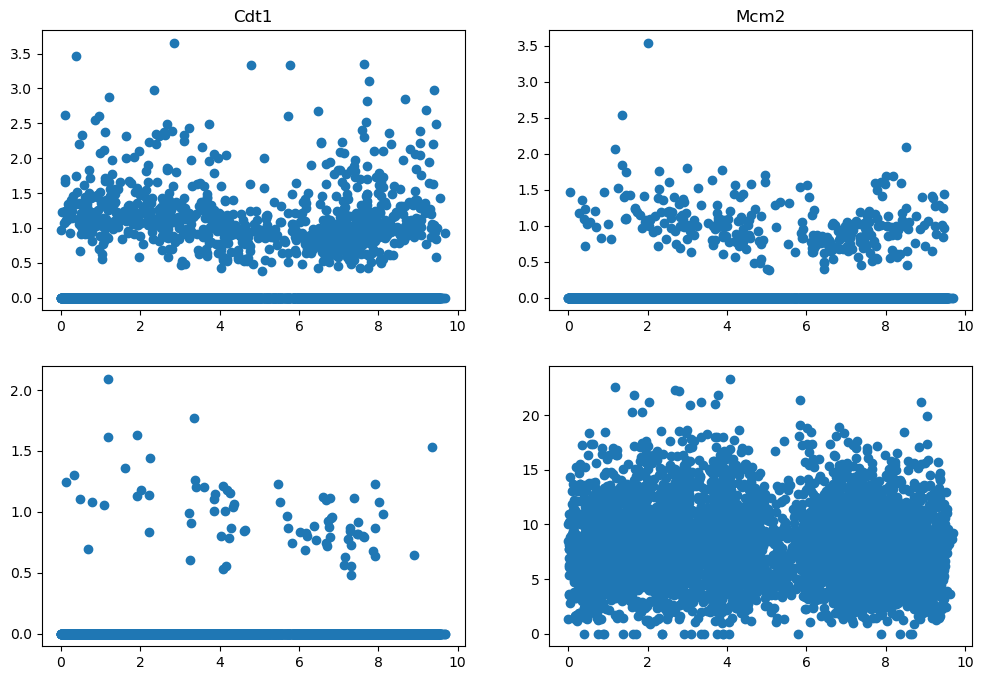

In [525]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

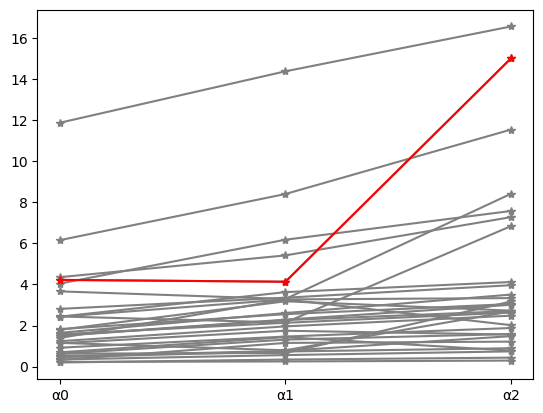

In [526]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [213]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

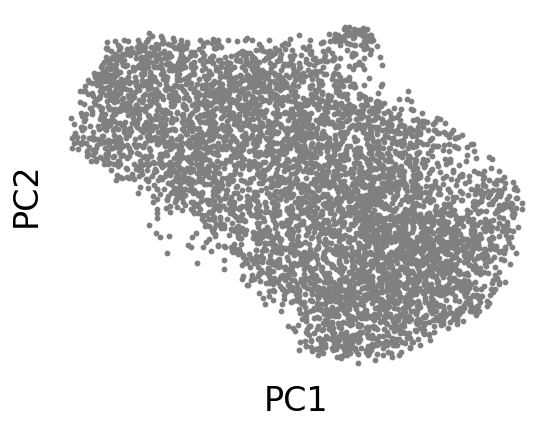

In [556]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [557]:
from multiprocessing import Pool

tau = (0,2,6,10)
topo = np.array([[0,1,2,0]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,params={"r":rd,"Ub":Ub},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

-450.62632900543616

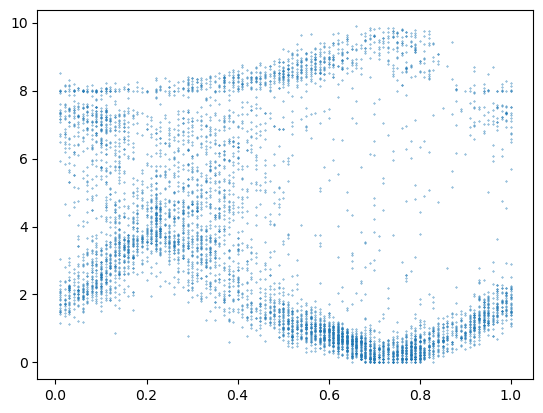

In [587]:
traj = trajs[np.argmax(elbos)]
plt.scatter(their_adata.obs['cell_cycle_theta'],traj.Q[:,0] @ traj.t,s=0.1)
np.max(elbos)

[ 0.          3.97189711  7.92246844 10.        ]


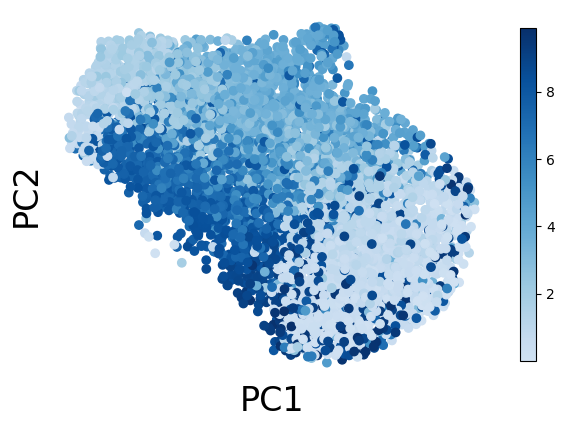

In [588]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [574]:
traj_tau = Trajectory(topo, tau, model="two_species_ss_tau",verbose=1)
traj_tau = traj_tau.fit(X,warm_start=True,fit_tau=True,params=params,Q=traj.Q.copy(),parallel=True,n_threads=10,epoch=10)
traj = traj_tau

fitting with warm start


100%|██████████| 10/10 [02:15<00:00, 13.51s/it]


[ 0.          3.97189711  7.92246844 10.        ]


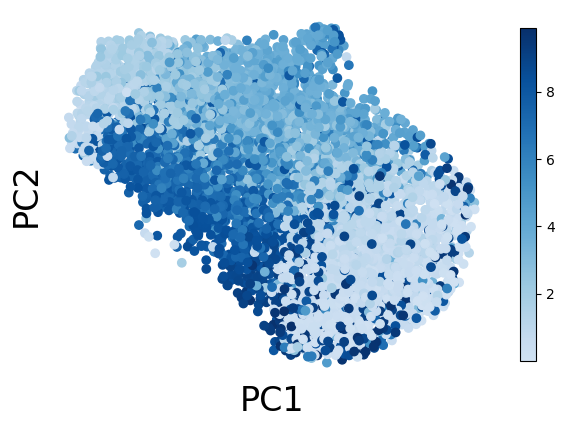

In [589]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

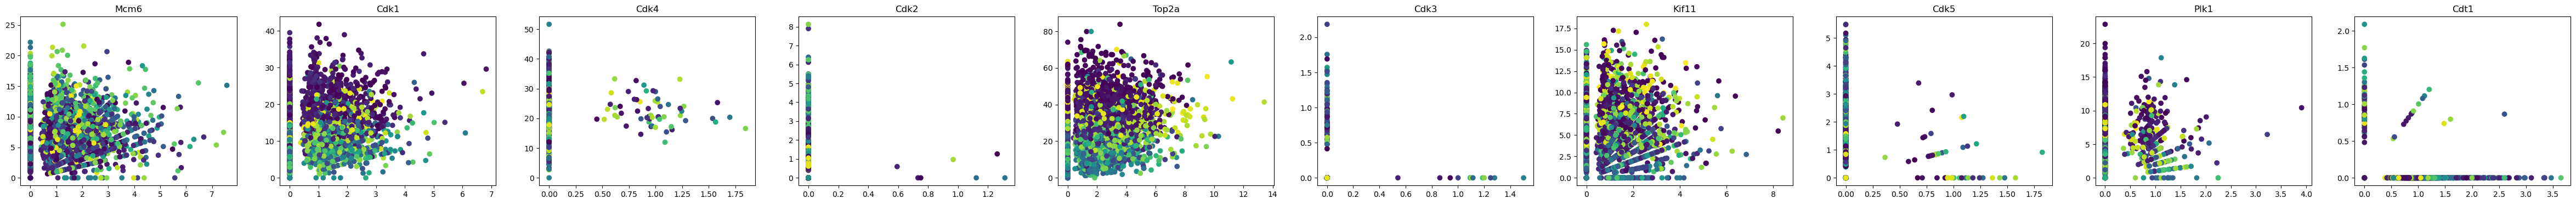

In [590]:
plot_marker_genes = marker_genes
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

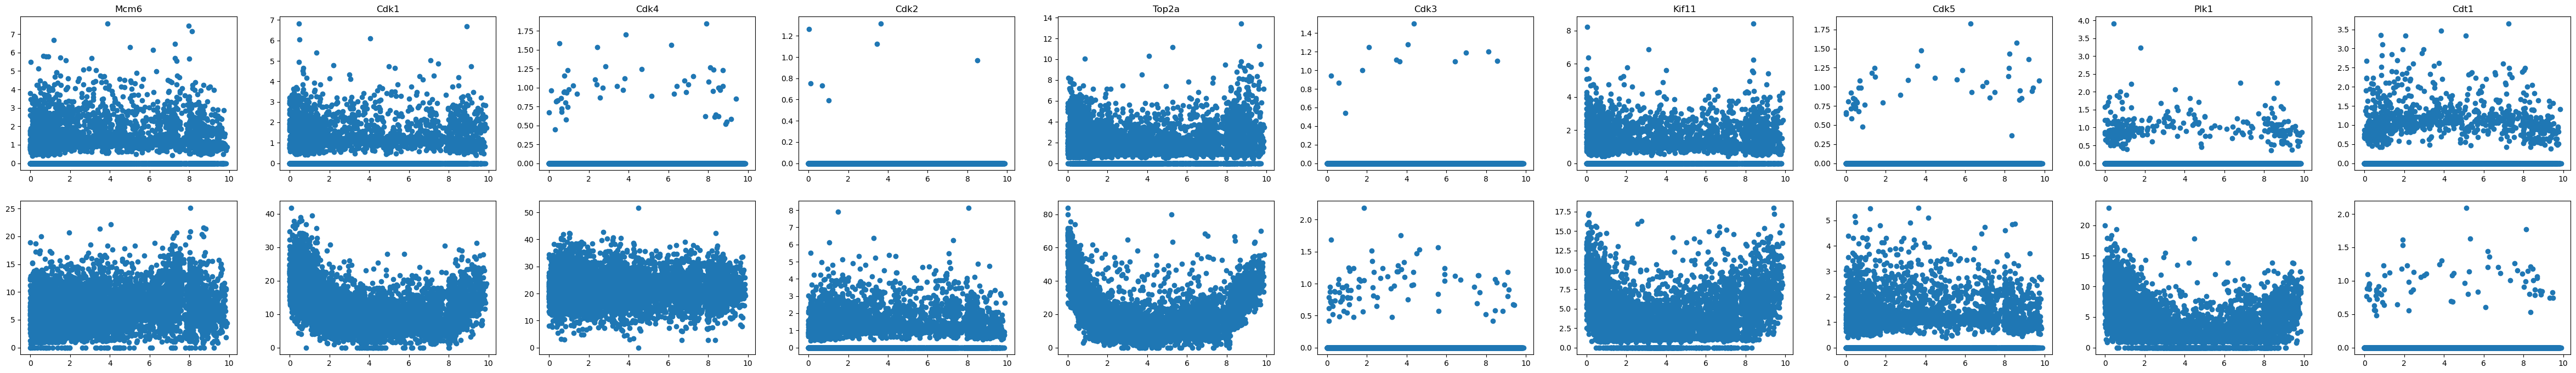

In [591]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

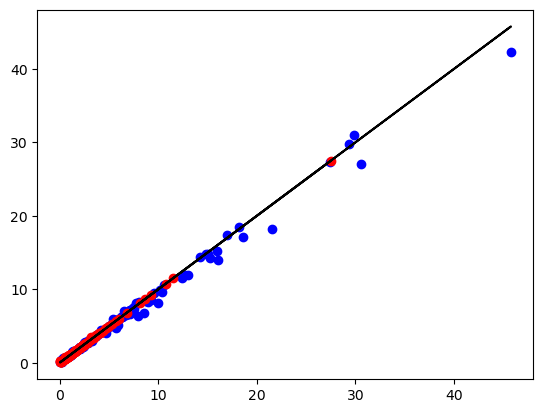

In [592]:
Y = traj.get_Y_hat(traj.theta, traj.t, traj.tau, traj.topo, traj.params)
plt.plot(Y[0,0,:,0],Y[0,0,:,0],'k-')
plt.plot(Y[0,0,:,1],Y[0,0,:,1],'k-')
plt.scatter(Y[0,0,:,1],Y[0,-1,:,1],color='b')
plt.scatter(Y[0,0,:,0],Y[0,-1,:,0],color='r')

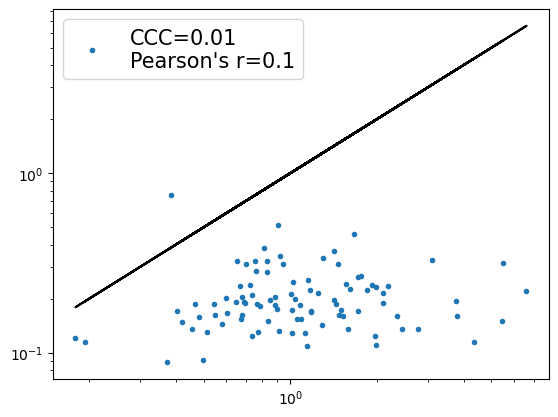

In [621]:
A = traj_tau.theta[:,-1]
B = slam_gamma[fitted_idx]
plot_cor(A,B)

/tmp/ipykernel_2130354/3999142630.py:8: RuntimeWarning: invalid value encountered in log
  Y = np.log(B[msk])


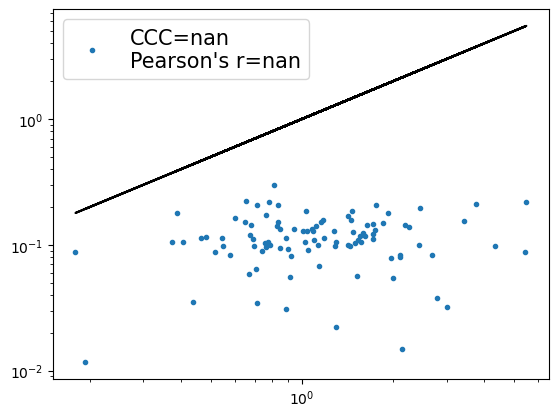

In [622]:
A = traj_tau.theta[:,-1]
B = Sharova_gamma[fitted_idx]
plot_cor(A,B)

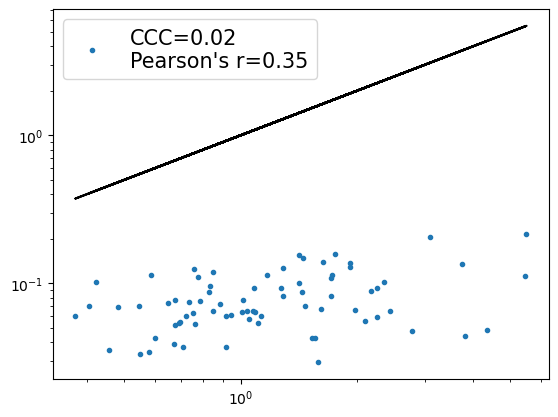

In [623]:
A = traj_tau.theta[:,-1]
B = Selbach_gamma[fitted_idx]
plot_cor(A,B)

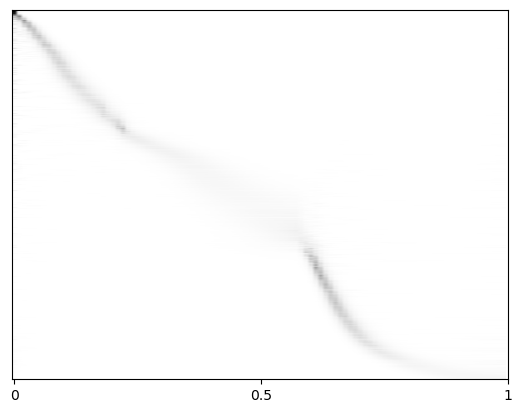

In [582]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '0.5', '1']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

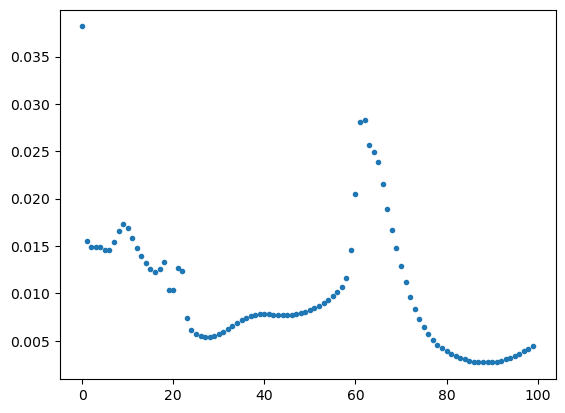

In [583]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

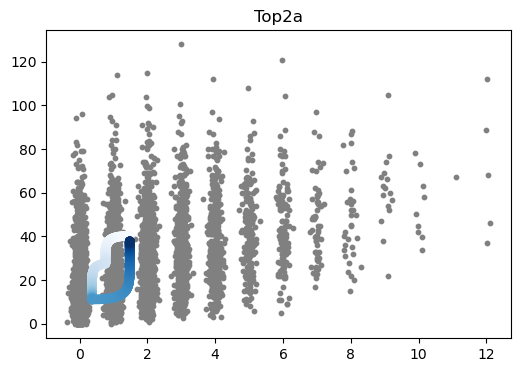

In [584]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

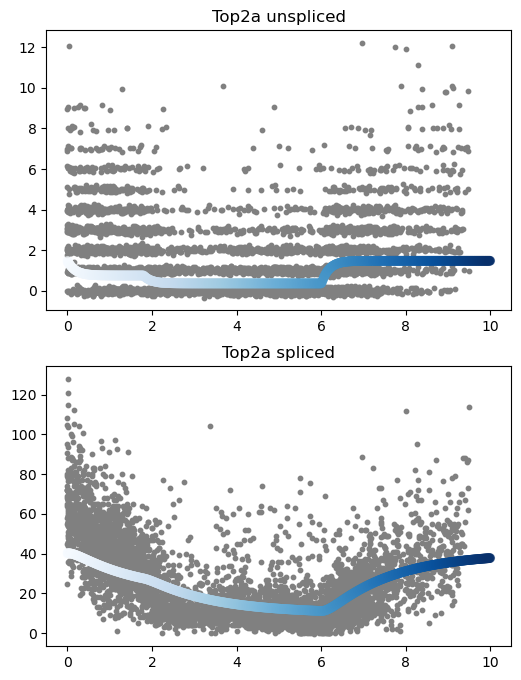

In [585]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

# Synthetic data

In [299]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [301]:
print(traj.elbos[-1])

-658.4752472018502


[ 0.         23.94425778 48.        ]


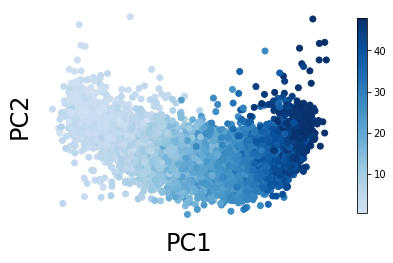

In [300]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

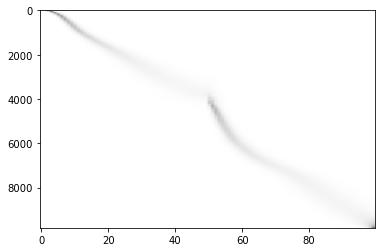

In [302]:
plot_t(traj,order_cells=True)

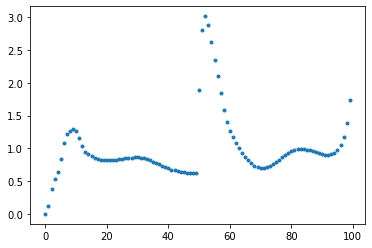

In [303]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

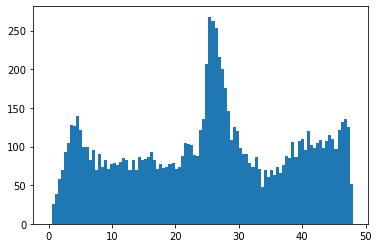

In [304]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

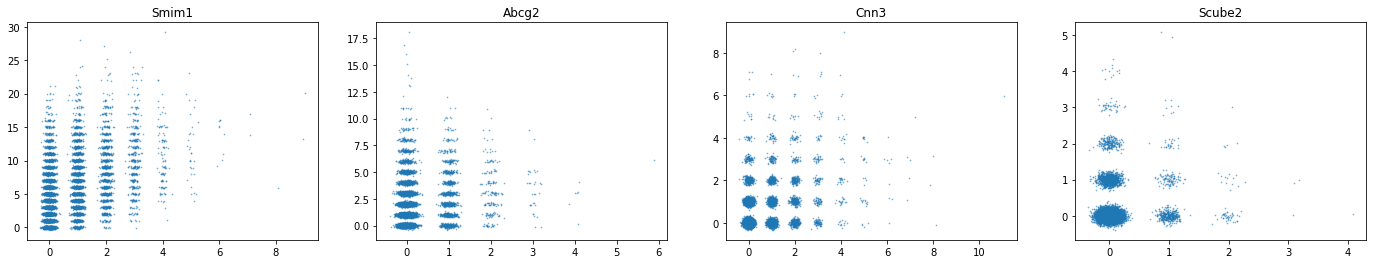

In [307]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [309]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

100%|██████████| 20/20 [12:44<00:00, 38.21s/it]


Text(0.5, 1.0, 'Random initialiazation')

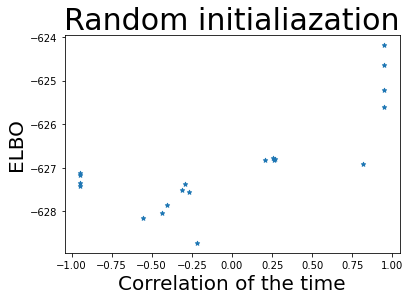

In [310]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)